In [32]:
#Склеить изображение (5 х 5)
#Убрать градиенты по краям
#Убрать линии склейки
#Выделить контуры животных
#Найти контур одного и того же животного на всех изображениях
#Отследить изменение площади
#Можно показать, какие части контурв растягиваются / сжимаются
#Отследить перемещение
!pip install opencv-python
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [33]:
def morph_open(img, morph_size):
    element = cv.getStructuringElement(cv.MORPH_RECT, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    return cv.morphologyEx(img, cv.MORPH_OPEN, element)

In [36]:
from os import listdir

def get_image_names():
    rows = []
    for y in range(5):
        rows.append([])
        for x in range(5):
            index = y * 5 + x + 1
            if index < 10:
                index = f"0{index}"
            directory = f"Well B1_{index}"
            rows[y].append(listdir(f"./data/{directory}"))
    count = len(rows[0][0])
    images = [[] for _ in range(count)]
    for y in range(5):
        for x in range(5):
            col = rows[y][x]
            if col is None:
                for i in range(count):
                    images[i].append(None)
                continue
            for i in range(count):
                images[i].append(col[i])
    return images

In [51]:
def get_images_from_names(image_names):
    count = len(image_names)
    images = [[] for _ in range(count)]
    for i in range(count):
        for j in range(25):
            index = j + 1
            if index < 10:
                index = f"0{index}"
            images[i].append(cv.imread(f"./data/Well B1_{index}/{image_names[i][j]}"))
    return images

In [52]:
def create_white(max_x, max_y, color = 255):
    return np.zeros((max_y, max_x, 3), np.uint8) + color

In [53]:
def combine_images():
    images = get_images_from_names(get_image_names())
    max_x = images[0][0].shape[1]
    max_y = images[0][0].shape[0]
    final_images = []
    for i in range(count):
        white = create_white(max_x * 5, max_y * 5)
        final_images.append(white)
        for y in range(5):
            for x in range(5):
                index = y * 5 + x
                white[y * max_y:(y + 1) * max_y, x * max_x:(x + 1) * max_x] = images[i][index][:]
    return final_images

In [65]:
image = images[0]
def preprocessing(image):
    return 255 - cv.cvtColor(image,cv.COLOR_BGR2GRAY)

def cut(image, x, y, w, h):
    white = create_white(image.shape[1], image.shape[0], 0)
    cv.rectangle(white, (x, y), (x + w, y + h), (1, 1, 1), -1)
    white = cv.cvtColor(white, cv.COLOR_BGR2GRAY)
    return white * cut

def get_plants(image):
    preprocessed = preprocessing(image)
    x = 1400
    y = 2900
    w = 500
    h = 700
    
preprocessed = preprocessing(image)
cut_image = cut(preprocessed, 1400, 2900, 500, 700)
plt.imshow(cut_image)

KeyboardInterrupt: 

In [57]:
def retain_neighbored(image, threshold):
    out = np.zeros(image.shape, np.uint8)
    for y in range(1, image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            hasAllNeighbors = True
            hasAllNeighbors = hasAllNeighbors and image[y + 1, x + 1] > threshold
            hasAllNeighbors = hasAllNeighbors and image[y + 1, x - 1] > threshold            
            hasAllNeighbors = hasAllNeighbors and image[y - 1, x - 1] > threshold            
            hasAllNeighbors = hasAllNeighbors and image[y - 1, x + 1] > threshold   
            if hasAllNeighbors:
                out[y, x] = image[y, x]
    return out

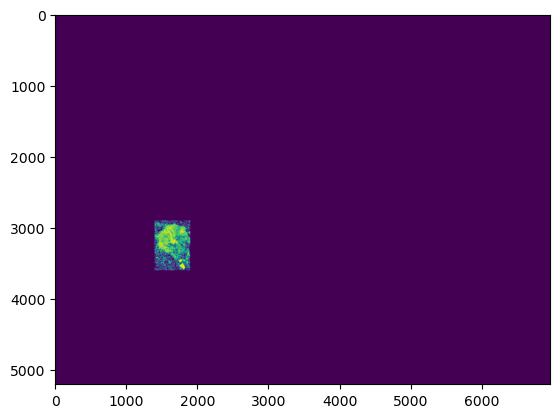

In [58]:
deleted = retain_neighbored(object_mask, 100)
plt.imshow(deleted)

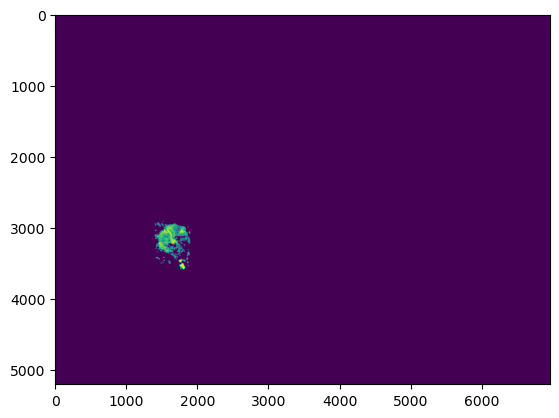

In [59]:
opened = morph_open(deleted, 5)
plt.imshow(opened)

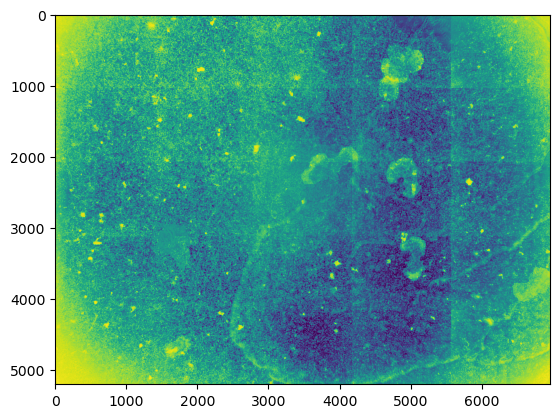

In [60]:
plants = cut - 0.4 * opened
plt.imshow(plants)

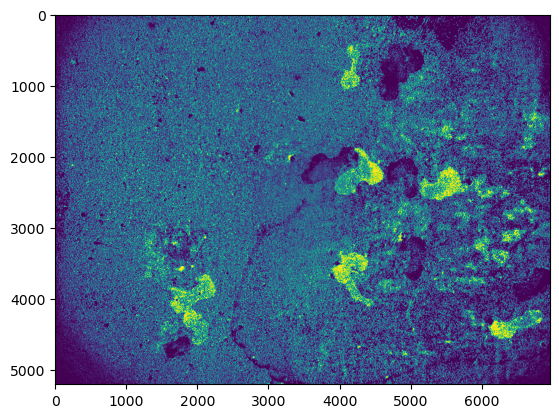

In [61]:
_, objects = cv.threshold(preprocessing(final_images[83]) - plants, 25, 255, cv.THRESH_BINARY)
plt.imshow(objects)

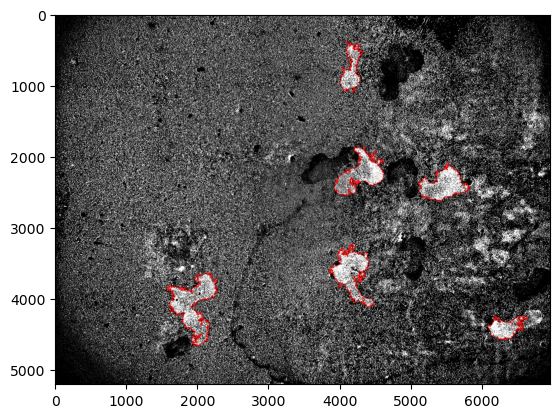

In [64]:
converted = objects.astype('uint8')
contours, hierarchy = cv.findContours(converted, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
colored = cv.cvtColor(converted, cv.COLOR_BGR2RGB)
max_lengths = [(0, None)] * 5 #(length, contour)
for contour in contours:
    contour_size = 1
    for length in contour.shape:
        contour_size = contour_size * length
    max_lengths.append((contour_size, contour))
    max_lengths = list(sorted(max_lengths, key=lambda c: c[0]))[-6:]
new_contours = list(reversed(list(map(lambda c: c[1], max_lengths))))
cv.drawContours(colored, new_contours, -1, (255, 0, 0), 3)
plt.imshow(colored)

In [31]:
def mask_of_contour(contour, max_x, max_y):
    white = create_white(max_x, max_y)
    cv.fillPoly(white, pts=np.int32([contour.reshape((contour.shape[0], 2))]), color=(255, 0, 0))
    return white

def bounding_box(contour):
    contour = contour.reshape((contour.shape[0], 2))
    first_x = contour[0][0]
    first_y = contour[0][1]
    last_x = 0
    last_y = 0
    for point in contour:
        x = point[0]
        y = point[1]
        if x < first_x:
            first_x = x
        if y < first_y:
            first_y = y
        if x + 1 > last_x:
            last_x = x + 1
        if y + 1 > last_y:
            last_y = y + 1
    return (first_x, first_y, last_x, last_y)

def area_from_contour(contour, max_x, max_y):
    mask = cv.cvtColor(mask_of_contour(contour, max_x, max_y), cv.COLOR_BGR2GRAY)
    
    first_x, first_y, last_x, last_y = bounding_box(contour)
    area = 0
    for y in range(first_y, last_y):
        for x in range(first_x, last_x):
            if mask[y, x] < 255:
                area += 1
    
    return area

for contour in new_contours:
    print(f"{area_from_contour(contour, images[0][0].shape[1], images[0][0].shape[0])} pixels")

299890 pixels
226225 pixels
213821 pixels
105738 pixels
193292 pixels
96442 pixels


In [178]:
def pipeline(image, plants):
    _, objects = cv.threshold(preprocessing(image) - plants, 25, 255, cv.THRESH_BINARY)
    converted = objects.astype('uint8')
    contours, hierarchy = cv.findContours(converted, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    max_lengths = [(0, None)] * 5 #(length, contour)
    for contour in contours:
        contour_size = 1
        for length in contour.shape:
            contour_size = contour_size * length
        max_lengths.append((contour_size, contour))
        max_lengths = list(sorted(max_lengths, key=lambda c: c[0]))[-5:]
    return list(reversed(list(map(lambda c: c[1], max_lengths))))

start = time.time()
y = []
x = [i for i in range(len(final_images))]
for i in range(len(final_images)):
    image = final_images[i]
    contours = pipeline(image, plants)
    contour = contours[0]
    area = area_from_contour(contour)
    y.append(area)
end = time.time()
print(end - start)

1921.353141784668


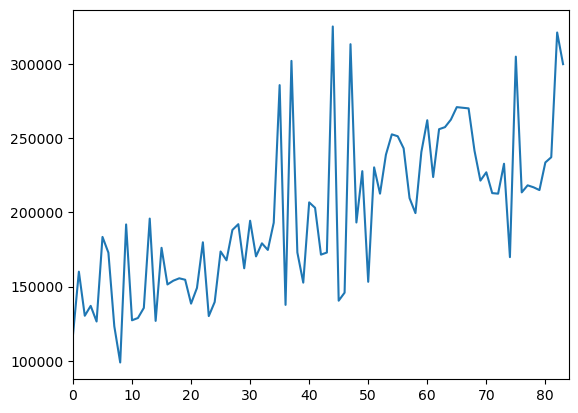

In [179]:
plt.xlim([0, len(final_images)])
plt.plot(x, y)